# 2-dimensional NICE
I try to learn a bivariate gaussian distribution

In [86]:
cfg = {
    'TRAIN_BATCH_SIZE': 64,
    'TRAIN_EPOCHS': 40,
    'NUM_COUPLING_LAYERS': 4,
    'NUM_NET_LAYERS': 6,  
    'NUM_HIDDEN_UNITS': 100,
    #'MODEL_SAVE_PATH': './saved_models/cifar10/'
}

In [87]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from torch.distributions import Distribution, Uniform
import numpy as np

In [88]:
class NICE(nn.Module):
  def __init__(self, data_dim, num_coupling_layers=3):
    super().__init__()

    self.data_dim = data_dim

    # alternating mask orientations for consecutive coupling layers
    masks = [self._get_mask(data_dim, orientation=(i % 2 == 0)) for i in range(num_coupling_layers)]

    self.coupling_layers = nn.ModuleList([CouplingLayer(
        data_dim=data_dim, 
        hidden_dim=cfg['NUM_HIDDEN_UNITS'], 
        mask=masks[i], 
        num_layers=cfg['NUM_NET_LAYERS'])
        for i in range(num_coupling_layers)])

    self.scaling_layer = ScalingLayer(data_dim=data_dim)
    self.prior = LogisticDistribution()

  def forward(self, x, invert=False):
    if not invert:
      z, log_det_jacobian = self.f(x)
      log_likelihood = torch.sum(self.prior.log_prob(z), dim=1) + log_det_jacobian
      return z, log_likelihood

    return self.f_inverse(x)

  def f(self, x):
    z = x
    log_det_jacobian = 0
    for i, coupling_layer in enumerate(self.coupling_layers):
      z, log_det_jacobian = coupling_layer(z, log_det_jacobian)
    z, log_det_jacobian = self.scaling_layer(z, log_det_jacobian)
    return z, log_det_jacobian

  def f_inverse(self, z):
    x = z
    x, _ = self.scaling_layer(x, 0, invert=True)
    for i, coupling_layer in reversed(list(enumerate(self.coupling_layers))):
      x, _ = coupling_layer(x, 0, invert=True)
    return x

  def sample(self, num_samples):
    z = self.prior.sample([num_samples, self.data_dim]).view(num_samples, self.data_dim)
    print(z)
    return self.f_inverse(z)

  def _get_mask(self, dim, orientation=True):
    mask = np.zeros(dim)
    mask[::2] = 1.
    if orientation:
      mask = 1. - mask # flip mask orientation
    mask = torch.tensor(mask)
    return mask.float()

In [89]:
class CouplingLayer(nn.Module):
  """
  Implementation of the additive coupling layer from section 3.2 of the NICE
  paper.
  """

  def __init__(self, data_dim, hidden_dim, mask, num_layers=4):
    super().__init__()

    assert data_dim % 2 == 0

    self.mask = mask

    modules = [nn.Linear(data_dim, hidden_dim), nn.LeakyReLU(0.2)]
    for i in range(num_layers - 2):
      modules.append(nn.Linear(hidden_dim, hidden_dim))
      modules.append(nn.LeakyReLU(0.2))
    modules.append(nn.Linear(hidden_dim, data_dim))

    self.m = nn.Sequential(*modules)

  def forward(self, x, logdet, invert=False):
    if not invert:
      x1, x2 = self.mask * x, (1. - self.mask) * x
      y1, y2 = x1, x2 + (self.m(x1) * (1. - self.mask))
      return y1 + y2, logdet

    # Inverse additive coupling layer
    y1, y2 = self.mask * x, (1. - self.mask) * x
    x1, x2 = y1, y2 - (self.m(y1) * (1. - self.mask))
    return x1 + x2, logdet


class ScalingLayer(nn.Module):
  """
  Implementation of the scaling layer from section 3.3 of the NICE paper.
  """
  def __init__(self, data_dim):
    super().__init__()
    self.log_scale_vector = nn.Parameter(torch.randn(1, data_dim, requires_grad=True))

  def forward(self, x, logdet, invert=False):
    log_det_jacobian = torch.sum(self.log_scale_vector)

    if invert:
        return torch.exp(- self.log_scale_vector) * x, logdet - log_det_jacobian

    return torch.exp(self.log_scale_vector) * x, logdet + log_det_jacobian

In [90]:
class LogisticDistribution(Distribution):
    def __init__(self):
        super().__init__()

    def log_prob(self, x):
        return -(F.softplus(x) + F.softplus(-x))
    
    def prob(self, x):
        return torch.exp(torch.sum(self.log_prob(x)))

    def sample(self, size):
        z = Uniform(torch.FloatTensor([0.]), torch.FloatTensor([1.])).sample(size)
        return torch.log(z) - torch.log(1. - z)

In [91]:
points = np.random.multivariate_normal([1, 5], [[10, 0], [0, 1]], 30000)

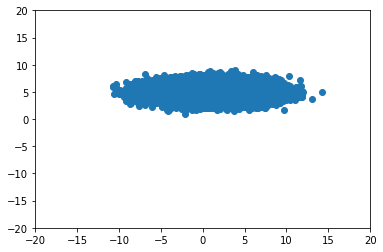

In [92]:
def show_sampled_points(points):
    x = []
    y = []
    for i in points:
        x.append(i[0])
        y.append(i[1])
    plt.scatter(x, y)
    plt.xlim([-20, 20])
    plt.ylim([-20, 20])
    plt.show()

show_sampled_points(points)

In [93]:
transform = transforms.ToTensor()
dataloader = torch.utils.data.DataLoader(dataset=points, batch_size=cfg['TRAIN_BATCH_SIZE'], shuffle=True, pin_memory=True)

In [94]:
def train(model, epochs, dataloader):
    model.train()
    opt = optim.Adam(model.parameters())
    for i in range(epochs):
        mean_likelihood = 0.0
        num_minibatches = 0

        for batch_id, x in enumerate(dataloader):
            x = x.view(-1, 2) #+ torch.rand(2) / 256. 
            #x = torch.clamp(x, 0, 1) 
            z, likelihood = model(x.float())
            #print(likelihood)
            loss = -torch.mean(likelihood) # NLL
            loss.backward()
            opt.step()
            model.zero_grad()
            mean_likelihood -= loss
            num_minibatches += 1

        mean_likelihood /= num_minibatches
        if i % 10 == 0:
            print('Epoch {} completed. Log Likelihood: {}'.format(i, mean_likelihood))

In [95]:
model = NICE(data_dim=2, num_coupling_layers=4)

In [96]:
train(model, 150, dataloader)

Epoch 0 completed. Log Likelihood: -5.290795803070068
Epoch 10 completed. Log Likelihood: -4.01470947265625
Epoch 20 completed. Log Likelihood: -4.006886005401611
Epoch 30 completed. Log Likelihood: -4.0043110847473145
Epoch 40 completed. Log Likelihood: -3.9997756481170654
Epoch 50 completed. Log Likelihood: -3.99733829498291
Epoch 60 completed. Log Likelihood: -3.9974653720855713
Epoch 70 completed. Log Likelihood: -3.996757984161377
Epoch 80 completed. Log Likelihood: -3.9966049194335938
Epoch 90 completed. Log Likelihood: -3.9969096183776855
Epoch 100 completed. Log Likelihood: -3.996242046356201
Epoch 110 completed. Log Likelihood: -3.995957612991333
Epoch 120 completed. Log Likelihood: -3.996107578277588
Epoch 130 completed. Log Likelihood: -3.9963529109954834
Epoch 140 completed. Log Likelihood: -3.9958271980285645


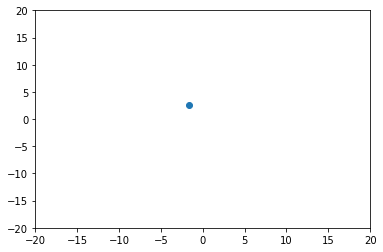

Probability of the generated point, according to the logistic distribution: tensor(0.0092)


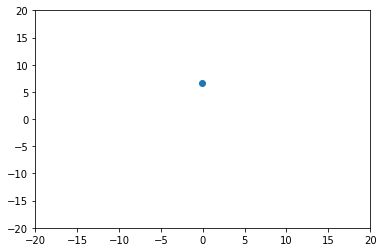

In [50]:
# campiono da una logistica
logistic = LogisticDistribution()
random_sample = logistic.sample((1, 2)).view((1, 2)) 
show_sampled_points(random_sample.detach().numpy())
print('Probability of the generated point, according to the logistic distribution:', logistic.prob(random_sample)) 

# lo trasformo nella gaussiana usando l'inversa
random_sample = random_sample.view((-1, 2))
trasf = model.f_inverse(random_sample)
trasf = trasf.view((1, 2))
show_sampled_points(trasf.detach().numpy())

In [98]:
from scipy import stats
for t in points[:10]:
    print('point:', t)
    print('probability:', stats.multivariate_normal.pdf(t, mean=[1,5], cov=[[10,0], [0,1]]))
    t = torch.from_numpy(t)
    z, loglikelihood = model.forward(t.float())
    print('Log Likelihood =', loglikelihood.detach().numpy()[0])
    print('Probability =', torch.exp(loglikelihood).detach().numpy()[0])
    print('')

point: [-3.01921722  5.2608407 ]
probability: 0.021690218034636877
Log Likelihood = -3.9021196
Probability = 0.020199051

point: [1.35701329 5.84472692]
probability: 0.03500290143831062
Log Likelihood = -3.4195857
Probability = 0.03272599

point: [-0.02918264  5.46309261]
probability: 0.04287965358802647
Log Likelihood = -3.0672848
Probability = 0.04654737

point: [6.53154866 5.24702963]
probability: 0.010571612201992178
Log Likelihood = -4.7983828
Probability = 0.008243067

point: [1.69865617 6.96695952]
probability: 0.007097302338252103
Log Likelihood = -5.1201324
Probability = 0.0059752315

point: [-2.0123539   2.76589917]
probability: 0.0026360157637245734
Log Likelihood = -5.754653
Probability = 0.0031680057

point: [0.95237891 4.65221054]
probability: 0.047370208693406565
Log Likelihood = -2.8402784
Probability = 0.058409404

point: [7.25285236 4.44567097]
probability: 0.0061106747329350295
Log Likelihood = -5.2660456
Probability = 0.005163991

point: [0.61889699 6.0616335 ]
prob